In [1]:
!pip install wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns

import matplotlib.pyplot as plt
from wordcloud import WordCloud

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()



In [3]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [4]:


df = pd.read_csv("IMDB Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
def preprocess_baseline(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

def preprocess_lemma(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in stop_words]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

df['clean_review'] = df['review'].apply(preprocess_baseline)
df['clean_lemma'] = df['review'].apply(preprocess_lemma)
df.head()



,review,sentiment,clean_review,clean_lemma
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,petter mattei love time money visually stunnin...


In [6]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_review'])
y = df['sentiment'].map({'positive':1, 'negative':0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print("=== Logistic Regression (Baseline Preprocessing) ===")
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression (Baseline Preprocessing) ===
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [7]:
# Vectorize with lemma version
X_lemma = vectorizer.fit_transform(df['clean_lemma'])
y = df['sentiment'].map({'positive':1, 'negative':0})

X_train, X_test, y_train, y_test = train_test_split(X_lemma, y, test_size=0.2, random_state=42)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
print("=== Naive Bayes on Lemmatized Text ===")
print(classification_report(y_test, y_pred_nb))


=== Naive Bayes on Lemmatized Text ===
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4961
           1       0.85      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



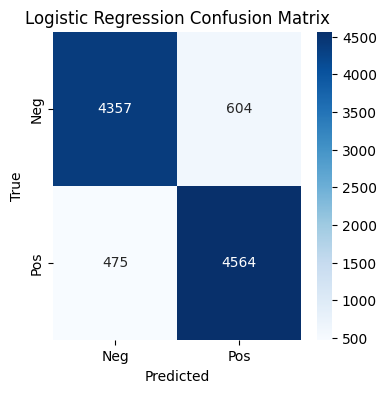

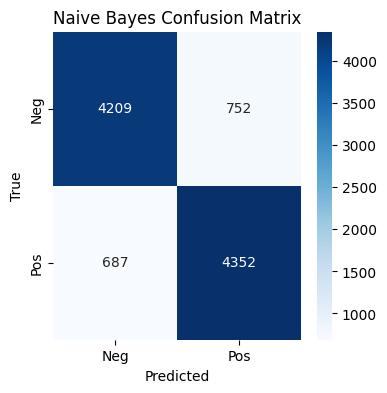

In [8]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

plot_cm(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")
plot_cm(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")


In [9]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression (on lemma)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

def get_scores(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return {"Model": name, "Accuracy": acc, "Precision": precision, "Recall": recall, "F1": f1}

results = []
results.append(get_scores("Logistic Regression (Lemma)", y_test, y_pred_lr))
results.append(get_scores("Naive Bayes (Lemma)", y_test, y_pred_nb))

pd.DataFrame(results)


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (Lemma),0.8886,0.888856,0.8886,0.888568
1,Naive Bayes (Lemma),0.8561,0.856146,0.8561,0.856087


In [10]:
sample_reviews = [
    "This movie was absolutely fantastic, I loved every minute!",
    "Terrible plot, boring acting, complete waste of time.",
    "It was okay, not great but not awful either."
]

sample_clean = [preprocess_lemma(r) for r in sample_reviews]
sample_vec = vectorizer.transform(sample_clean)

print("Manual Predictions:")
for review, pred in zip(sample_reviews, nb_model.predict(sample_vec)):
    label = "Positive" if pred == 1 else "Negative"
    print(f"{label} -> {review}")


Manual Predictions:
Positive -> This movie was absolutely fantastic, I loved every minute!
Negative -> Terrible plot, boring acting, complete waste of time.
Negative -> It was okay, not great but not awful either.


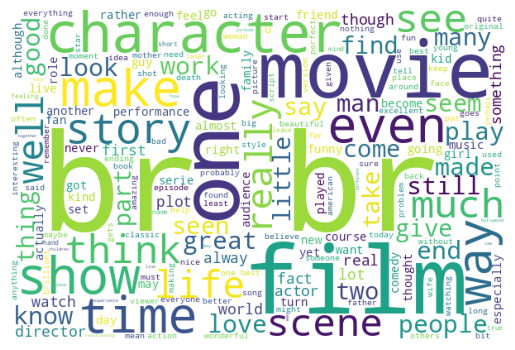

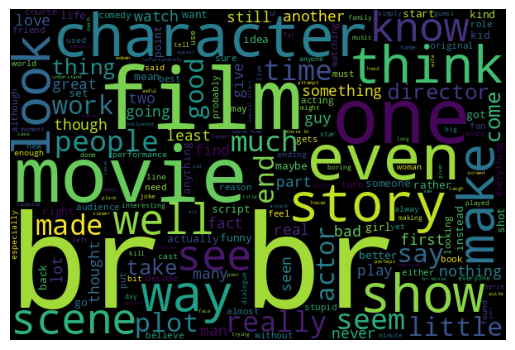

In [11]:
positive_text = " ".join(df[df['sentiment']=='positive']['clean_review'])
negative_text = " ".join(df[df['sentiment']=='negative']['clean_review'])

wc_pos = WordCloud(width=600, height=400, background_color="white").generate(positive_text)
wc_neg = WordCloud(width=600, height=400, background_color="black").generate(negative_text)

plt.imshow(wc_pos); plt.axis("off"); plt.show()
plt.imshow(wc_neg); plt.axis("off"); plt.show()